# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations

In [1]:
try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")

from itertools import product

import jax
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap
from jax.flatten_util import ravel_pytree

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import resample

tfpd = tfp.distributions

import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"



INFO[2023-01-02 14:45:29,603]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-01-02 14:45:29,603]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-01-02 14:45:29,604]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-01-02 14:45:29,605]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-01-02 14:45:29,605]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-01-02 14:45:29,606]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))  #N,2
y = vmap(xor_reduce)(x)[:, None]  #N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x, y):
    print(f"{input} -> {output}")


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [False]
[1. 1. 0. 0. 1. 0. 1.] -> [False]
[1. 1. 0. 0. 1. 0. 0.] -> [ True]
[1. 1. 0. 0. 0. 1. 1.] -> [False]
[1. 1. 0

In [3]:
from jax._src.nn.functions import softplus


# Define the likelihood, using Haiku as our framework for neural networks

def nn_model(x, is_training=False):
    mlp = hk.Sequential([hk.Linear(4),
                         jax.nn.sigmoid,
                         hk.Linear(1)])
    return mlp(x)


nn_model = hk.without_apply_rng(hk.transform(nn_model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = nn_model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)


def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = nn_model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 37


In [4]:
from jaxns import Prior, Model


# Build the model

def prior_model():
    params = yield Prior(tfpd.Uniform(-10 * jnp.ones(n_dims), 10. * jnp.ones(n_dims)), name='params')

    return params


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


/tmp/ipykernel_171480/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)
INFO[2023-01-02 14:45:31,259]: Sanity check...
INFO[2023-01-02 14:45:31,734]: Sanity check passed


In [5]:


# Create the nested sampler class. In this case without any tuning.
exact_ns = ExactNestedSampler(model=model, num_live_points=model.U_ndims * 20, max_samples=1e6,
                              num_parallel_samplers=len(jax.devices()),
                              uncert_improvement_patience=2)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)


/tmp/ipykernel_171480/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 232752
# samples: 4664
# slices: 166500.0
# slices / acceptance: 75.0
# likelihood evals / sample: 49.9
# likelihood evals / slice: 1.4
--------
logZ=-2.606 +- 0.03
H=2.8
ESS=1387
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: -0.3 +- 5.7 | -8.0 / -0.5 / 7.6 | -9.2 | -9.2
params[1]: -0.5 +- 5.9 | -8.3 / -1.0 / 7.7 | 2.9 | 2.9
params[2]: -0.4 +- 5.8 | -8.1 / -0.5 / 7.8 | -3.5 | -3.5
params[3]: -0.3 +- 5.9 | -8.3 / -0.6 / 8.0 | -7.2 | -7.2
params[4]: 0.1 +- 5.9 | -7.9 / 0.0 / 8.3 | 7.9 | 7.9
params[5]: -0.0 +- 5.8 | -7.8 / -0.3 / 8.2 | 7.5 | 7.5
params[6]: -0.2 +- 5.8 | -8.2 / -0.2 / 8.0 | -5.2 | -5.2
params[7]: 0.1 +- 5.8 | -8.0 / 0.2 / 8.2 | 5.3 | 5.3
params[8]: 0.4 +- 5.7 | -7.5 / 0.2 / 8.2 | 4.5 | 4.5
params[9]: 0.0 +- 5.8 | -8.1 / 0.2 / 8.0 | 5.7 | 5.7
params[10]: 0.2 +- 5.9 | -8.1 / 0.3 / 8.1 | -7.7 | -7.7
params[11]: 0.1 +- 5.8 | -7.8 / 0.3 / 

WARNING[2023-01-02 14:45:47,466]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


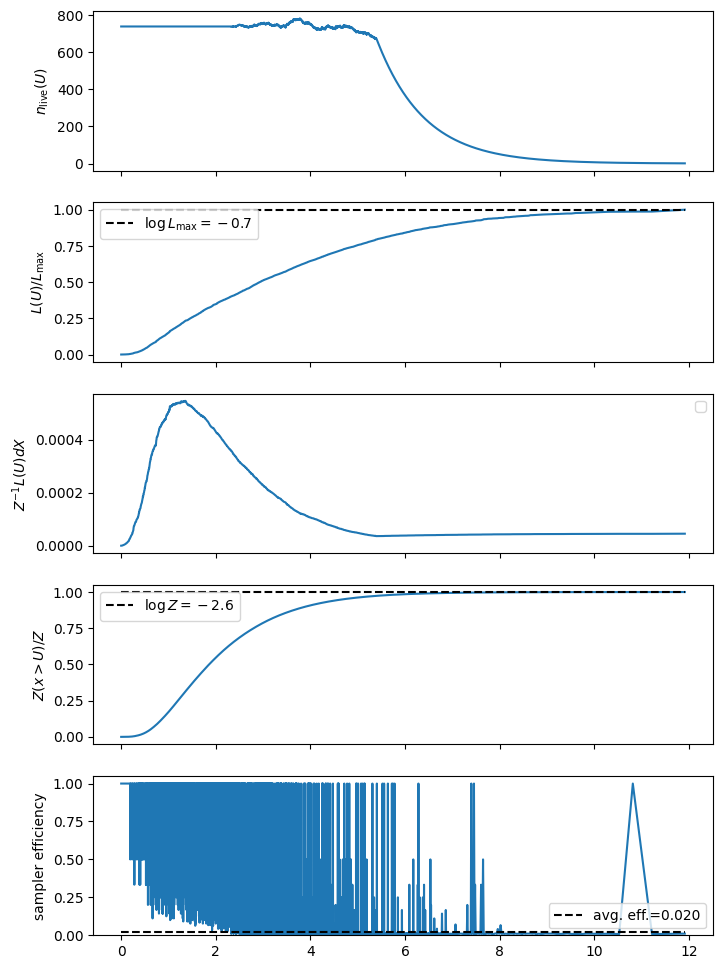

In [6]:
exact_ns.summary(results)
exact_ns.plot_diagnostics(results)

In [7]:
samples = resample(random.PRNGKey(45), results.samples, results.log_dp_mean, S=int(results.ESS), replace=True)


def predict(params):
    params_dict = unravel_func(params)
    logits = nn_model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:, 0]


predictions = vmap(predict)(samples['params'])

for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {jnp.percentile(predictions[:, i], jnp.asarray([5, 50, 95]))}")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [0.00119538 0.5295     0.99862754]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [8.8638382e-04 5.6590748e-01 9.9962133e-01]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [6.9584354e-04 4.9436647e-01 9.9942112e-01]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [6.9002114e-04 5.1315862e-01 9.9959594e-01]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [6.9185009e-04 4.8558635e-01 9.9913871e-01]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [5.6436699e-04 5.5808884e-01 9.9966884e-01]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [4.4042175e-04 4.9060485e-01 9.9927574e-01]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [3.215844e-04 5.205850e-01 9.997657e-01]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [8.0878026e-04 5.2828795e-01 9.9939418e-01]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [4.2686251e-04 5.1374996e-01 9.9965584e-01]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [4.0413858e-04 5.4680419e-01 9.9955279e-01]
11: [1. 1. 1. 0. 1. 0. 0.] -> [F

114: [0. 0. 0. 1. 1. 0. 1.] -> [ True] | pred: [6.8983930e-04 5.7975715e-01 9.9972671e-01]
115: [0. 0. 0. 1. 1. 0. 0.] -> [False] | pred: [2.7009472e-04 5.6083465e-01 9.9973756e-01]
116: [0. 0. 0. 1. 0. 1. 1.] -> [ True] | pred: [2.4540132e-04 5.2870715e-01 9.9959928e-01]
117: [0. 0. 0. 1. 0. 1. 0.] -> [False] | pred: [3.0577328e-04 5.3892511e-01 9.9955684e-01]
118: [0. 0. 0. 1. 0. 0. 1.] -> [False] | pred: [4.0760660e-04 5.5750960e-01 9.9975854e-01]
119: [0. 0. 0. 1. 0. 0. 0.] -> [ True] | pred: [2.2864839e-04 5.3602093e-01 9.9983060e-01]
120: [0. 0. 0. 0. 1. 1. 1.] -> [ True] | pred: [4.4976236e-04 5.3545463e-01 9.9973857e-01]
121: [0. 0. 0. 0. 1. 1. 0.] -> [False] | pred: [1.930726e-04 5.446255e-01 9.998070e-01]
122: [0. 0. 0. 0. 1. 0. 1.] -> [False] | pred: [4.5490084e-04 6.0386705e-01 9.9972159e-01]
123: [0. 0. 0. 0. 1. 0. 0.] -> [ True] | pred: [3.319435e-04 6.231395e-01 9.997840e-01]
124: [0. 0. 0. 0. 0. 1. 1.] -> [False] | pred: [2.0235739e-04 5.5002940e-01 9.9961090e-01]
125: 

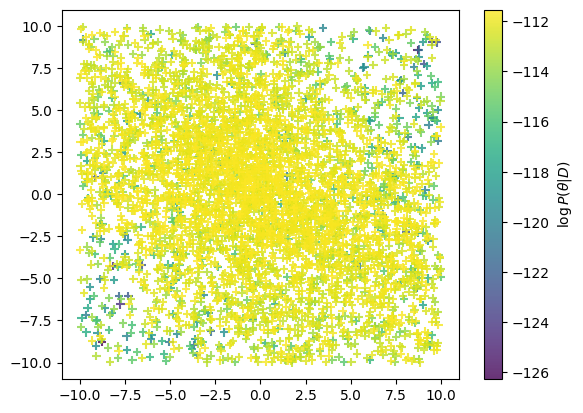

In [8]:

sc = plt.scatter(*results.samples['params'][:, -5:-3].T, marker='+', alpha=0.8, c=results.log_posterior_density)
plt.colorbar(sc, label=r'$\log P(\theta | D)$')
plt.show()

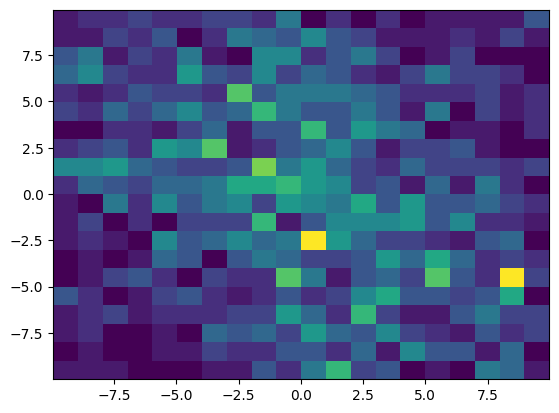

In [9]:
plt.hist2d(*samples['params'][:, -5:-3].T, bins=20)
plt.show()